In [ ]:
from google.colab import files,drive
import pandas as pd
import numpy as np
import io 
from skimage.io import imread
import torch.nn as nn
from PIL import Image
import torch
import os
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,Dataset

In [ ]:
# uploaded=files.upload()

In [ ]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
# path='/content/gdrive/My Drive/plantpathology/images' #Nishant
path='/content/gdrive/My Drive/plantpathology' #Ashish

traincsv=pd.read_csv(os.path.join('/content/gdrive/My Drive','train.csv'))
testcsv=pd.read_csv(os.path.join('/content/gdrive/My Drive','test.csv'))


In [ ]:

''' Class 0: Healthy
    Class 1: multiple
    Class 2: rust
    Class 3: scab'''
healthyidx=traincsv[traincsv['healthy']==1].index
multipleidx=traincsv[traincsv['multiple_diseases']==1].index
rustidx=traincsv[traincsv['rust']==1].index
scabidx=traincsv[traincsv['scab']==1].index

traincsv['Labels']=-1
traincsv['Labels'][healthyidx]=0
traincsv['Labels'][multipleidx]=1
traincsv['Labels'][rustidx]=2
traincsv['Labels'][scabidx]=3

traindata=traincsv.iloc[:1456]
testdata=traincsv.iloc[1456:]
print(traincsv)
# print(testcsv)


        image_id  healthy  multiple_diseases  rust  scab  Labels
0        Train_0        0                  0     0     1       3
1        Train_1        0                  1     0     0       1
2        Train_2        1                  0     0     0       0
3        Train_3        0                  0     1     0       2
4        Train_4        1                  0     0     0       0
...          ...      ...                ...   ...   ...     ...
1816  Train_1816        0                  0     0     1       3
1817  Train_1817        1                  0     0     0       0
1818  Train_1818        1                  0     0     0       0
1819  Train_1819        0                  0     1     0       2
1820  Train_1820        0                  0     0     1       3

[1821 rows x 6 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: Se

In [ ]:
 class data(Dataset):
  def __init__(self,type='train',transform=None):
    self.imagecsv=''
    if type=='test':
      self.imagecsv=testdata
      
    else:
      self.imagecsv=traindata
      
    self.path=path
    self.transform=transform
               
  def __len__(self):
    return len(self.imagecsv)
  def __getitem__(self,idx):
    i=self.imagecsv.iloc[idx,0]
    image = Image.open(os.path.join(self.path,i+'.jpg'))
    
    img = transforms.ToTensor()(image).unsqueeze(0)
    #image=imread(os.path.join(self.path,i+'.jpg'))
    #image=image[:1365,:1365]
    
    finalimage=self.transform(image)
    return finalimage,self.imagecsv.iloc[idx,5]
    
    

    

In [ ]:
trainset=data(transform=transforms.Compose([transforms.Resize([560,560]), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))]))
trainloader=DataLoader(dataset=trainset,batch_size=32,shuffle=True)
testset=data(type='test',transform=transforms.Compose([transforms.Resize([560,560]), 
                                                       
                                                       transforms.ToTensor(), 
                                                       transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))]))
testloader=DataLoader(dataset=testset,batch_size=32,shuffle=True)
dataiter=iter(trainloader)
testiter=iter(testloader)

In [ ]:
#With Augmentations
trainset=data(transform=transforms.Compose([transforms.Resize([560,560]), 
                                            transforms.RandomHorizontalFlip(p=0.5),
                                            transforms.RandomVerticalFlip(p=0.5),
                                            transforms.RandomAffine(degrees=45, translate=(0.5,0.5)), 
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))]))
trainloader=DataLoader(dataset=trainset,batch_size=32,shuffle=True)
testset=data(type='test',transform=transforms.Compose([transforms.Resize([560,560]), 
                                                       
                                                       transforms.ToTensor(), 
                                                       transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))]))
testloader=DataLoader(dataset=testset,batch_size=32,shuffle=True)
dataiter=iter(trainloader)
testiter=iter(testloader)

In [ ]:
# # # TRAINING MEAN AND STD
# mean = 0.
# std = 0.
# nb_samples = 0.
# for images,labels in trainloader:
    
#     batch_samples = trainloader.batch_size
#     images = images.view(batch_samples, 3, -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples  #[0.4069,0.5107,0.3149]
# std /= nb_samples   #[0.1900,0.1744,0.1722]


In [ ]:
# print(mean, std)

In [ ]:
# # #TEST MEAN AND STD
# mean = 0.
# std = 0.
# nb_samples = 0.
# for images,labels in testloader:
    
#     batch_samples = testloader.batch_size
#     images = images.view(batch_samples, 3, -1)
#     mean += images.mean(2).sum(0)
#     std += images.std(2).sum(0)
#     nb_samples += batch_samples

# mean /= nb_samples  #[0.3986, 0.4988, 0.3226]
# std /= nb_samples   #[0.1885, 0.1761, 0.1707]


In [ ]:
# print(mean,std)

In [ ]:

images,labels=dataiter.next()
testimages,testlabels=testiter.next()
print(testimages.size())
print(images.size())

print(images.size(1))
print(labels.size())

torch.Size([32, 3, 560, 560])
torch.Size([32, 3, 560, 560])
3
torch.Size([32])


In [ ]:
print(len(trainloader))
print(len(traincsv))

46
1821


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


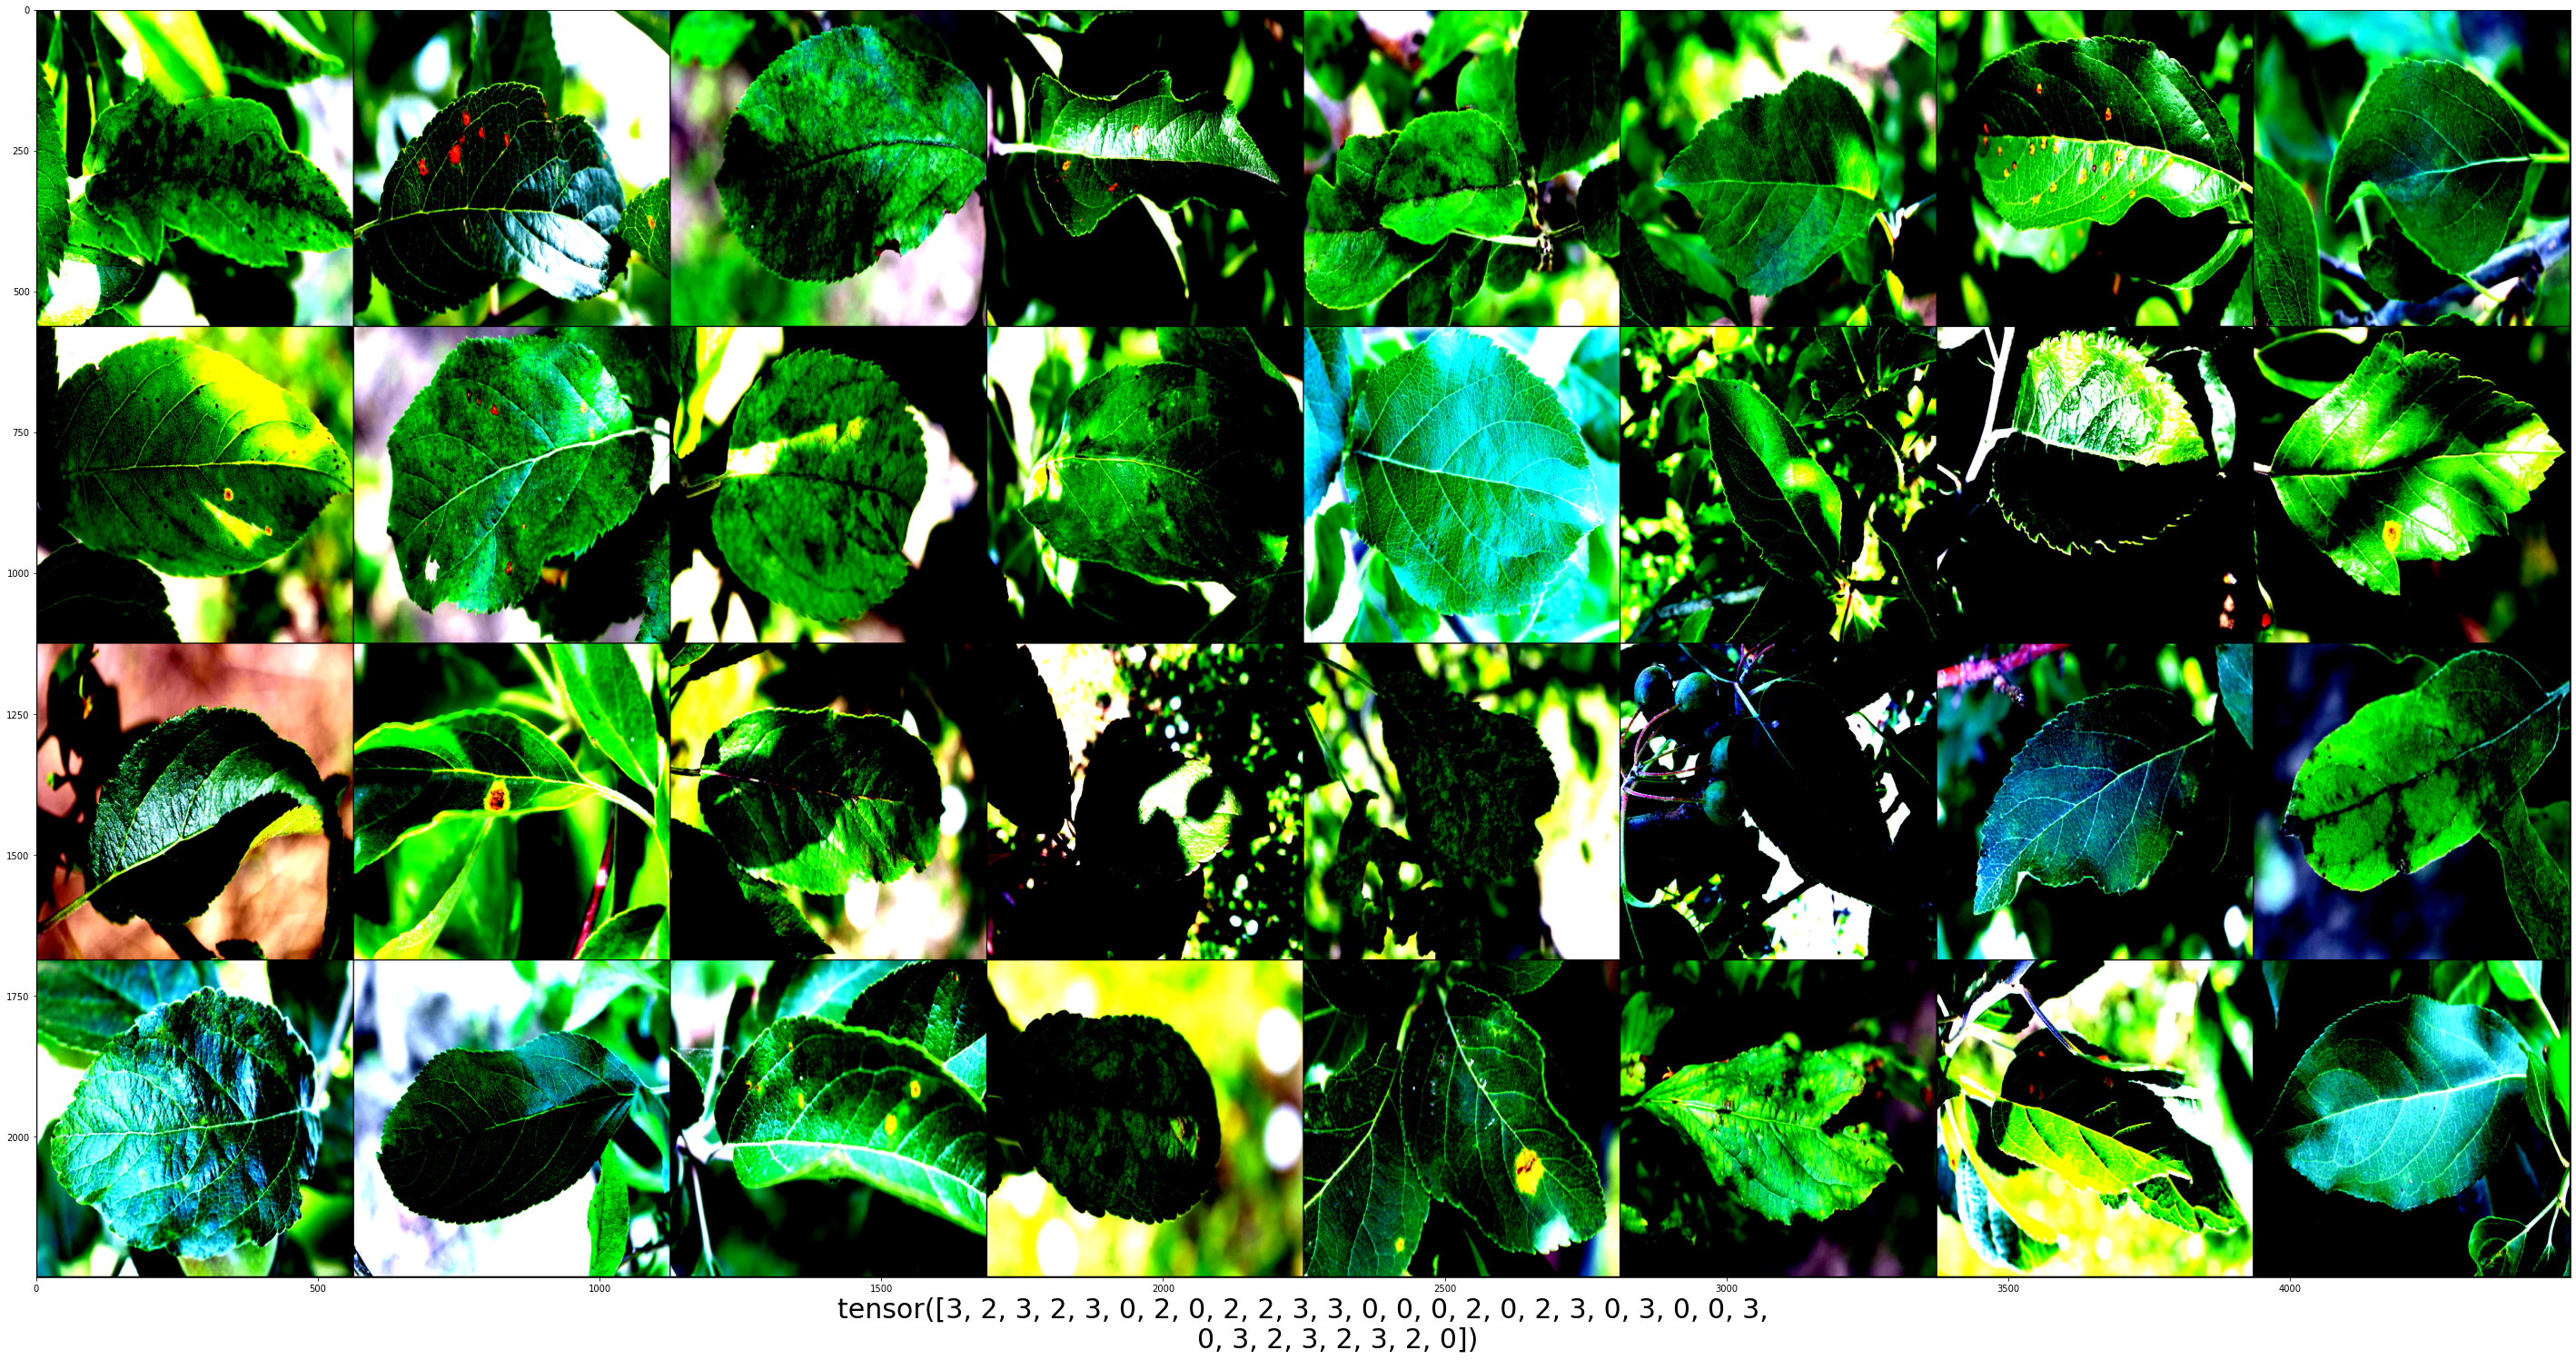

In [ ]:
plt.figure(figsize=(50,50))
def imshow(img):
  # img = img / 2 + 0.5     # unnormalize
  npimg = img.numpy()
  plt.xlabel(labels, fontsize=30)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# show images
imshow(torchvision.utils.make_grid(images))

In [ ]:
model=torchvision.models.resnet18(pretrained=True)

num_ftrs=model.fc.in_features
model.fc=nn.Sequential(nn.Linear(num_ftrs,1000),
                        nn.ReLU(),
    # nn.Linear(512,128),
    # nn.ReLU(),
    # nn.Linear(128,32),
    # nn
    nn.Linear(1000,4)
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [ ]:
model.load_state_dict(torch.load('/content/gdrive/My Drive/plantpath-resnet18.pt'))
# model.eval()


<All keys matched successfully>

In [ ]:
# model=CNN(8,32,64)
criterion=nn.CrossEntropyLoss()
optimizer=torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
#scheduler=torch.optim.lr_scheduler.StepLR(optimizer,step_size=25,gamma=0.05)

In [ ]:
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
for epoch in range(10):
  model.train(True)
  trainloss=0
  for x,y in trainloader:
    
    x,y=x.cuda(),y.cuda()

    yhat=model(x)
    optimizer.zero_grad()
    loss=criterion(yhat,y)
    loss.backward()
    optimizer.step()
    trainloss+=loss.item()
  
  print('Epoch {}  Loss: {}'.format(epoch,(trainloss/len(trainloader.dataset))))
  model.eval()
  testcorrect=0
  with torch.no_grad():
    for test_x,test_y in testloader:
      test_x,test_y=test_x.cuda(),test_y.cuda()
      yhat=model(test_x)
      _,z=yhat.max(1)
      testcorrect+=(test_y==z).sum().item()
      
print('Model Accuracy: ',(testcorrect/len(testloader.dataset)))
torch.save(model.state_dict(), 'plantpath-resnet18.pt')

Epoch 0  Loss: 0.01114929499166025
Epoch 1  Loss: 0.008917397036534417
Epoch 2  Loss: 0.00872504624159454
Epoch 3  Loss: 0.007555778332791485
Epoch 4  Loss: 0.007939367739299496
Epoch 5  Loss: 0.007724085991567636
Epoch 6  Loss: 0.007257453736511397
Epoch 7  Loss: 0.006894825369242456
Epoch 8  Loss: 0.007305486795523173
Epoch 9  Loss: 0.006030958468237748
Model Accuracy:  0.9397260273972603


In [ ]:
class testdata(Dataset):
  def __init__(self,transform=None):
    self.imagecsv=testcsv
    
    self.path=path
    self.transform=transform
    
               
  def __len__(self):
    return len(self.imagecsv)
  def __getitem__(self,idx):
    i=self.imagecsv.iloc[idx,0]
    image = Image.open(os.path.join(self.path,i+'.jpg'))
    # img = transforms.ToTensor()(image).unsqueeze(0)
    #image=imread(os.path.join(self.path,i+'.jpg'))
    #image=image[:1365,:1365]
    # augimage=self.augtransform(image=img)
    
    finalimage=self.transform(image)
    return finalimage
    
 

In [ ]:
finaltestdata=testdata(transform=transforms.Compose([transforms.Resize([560,560]), 
                                            transforms.ToTensor(), 
                                            transforms.Normalize((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))]))
finaltestloader=DataLoader(dataset=finaltestdata,batch_size=32)

In [ ]:

preds=np.zeros((1,4))
print(len(finaltestloader.dataset))
for image in finaltestloader:
  image=image.cuda()
  y=model(image)
  
  probabilities = nn.functional.softmax(y)
  probabilities=probabilities.cpu().detach().numpy()
  preds=np.append(preds,probabilities,axis=0)
  # print(preds)
  # break
preds=np.delete(preds,0,axis=0)
pred_df=pd.DataFrame(data=preds,columns=['healthy','multiple_diseases','rust','scab'])
pred_df.to_csv(r'/content/gdrive/My Drive/plantpathology/resnet18-submission.csv',index=False)
print(pred_df)

1821


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  
